In [0]:
import sys
import tarfile
import os
from six.moves import urllib

FLOWERS_URL = "http://download.tensorflow.org/example_images/flower_photos.tgz"
FLOWERS_PATH = os.path.join("datasets", "flowers")

def download_progress(count, block_size, total_size):
    percent = count * block_size * 100 // total_size
    sys.stdout.write("\rDownloading: {}%".format(percent))
    sys.stdout.flush()

def fetch_flowers(url=FLOWERS_URL, path=FLOWERS_PATH):
    if os.path.exists(FLOWERS_PATH):
        return
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, "flower_photos.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    flowers_tgz = tarfile.open(tgz_path)
    flowers_tgz.extractall(path=path)
    flowers_tgz.close()
    #os.remove(tgz_path)

In [0]:
#urllib.request.urlretrieve(FLOWERS_URL, os.path.join(FLOWERS_PATH,'flower_photos.tgz'), reporthook=download_progress)

In [0]:
flowers_root_path = os.path.join(FLOWERS_PATH, "flower_photos")
fetch_flowers()

In [0]:
for i in os.listdir(flowers_root_path):
  print(i)

tulips
daisy
dandelion
roses
LICENSE.txt
sunflowers


In [0]:
flower_classes = sorted([dirname for dirname in os.listdir(flowers_root_path)
                  if os.path.isdir(os.path.join(flowers_root_path, dirname))])
flower_classes

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [0]:
!ls datasets/flowers

flower_photos  flower_photos.tgz


In [0]:
!ls

datasets  sample_data


In [0]:
from collections import defaultdict

image_paths = defaultdict(list)

for flower_class in flower_classes:
    image_dir = os.path.join(flowers_root_path, flower_class)
    for filepath in os.listdir(image_dir):
        if filepath.endswith(".jpg"):
            image_paths[flower_class].append(os.path.join(image_dir, filepath))

In [0]:
for paths in image_paths.values():
  paths.sort()

class: daisy


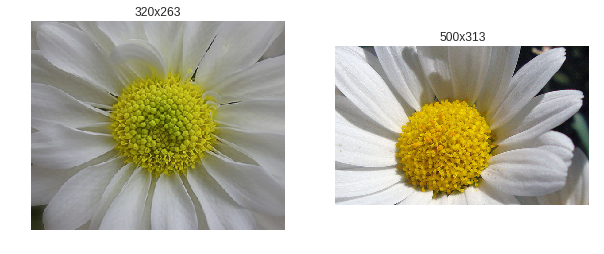

class: dandelion


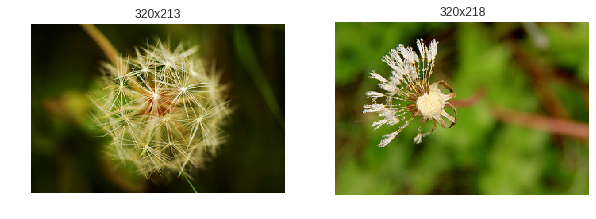

class: roses


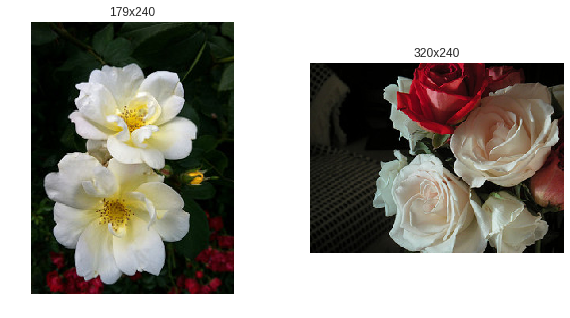

class: sunflowers


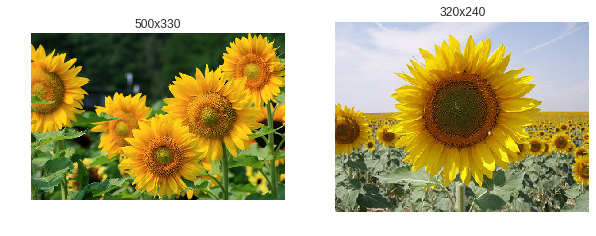

class: tulips


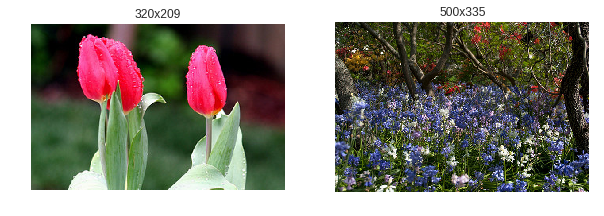

In [0]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

channels = 3
ex_per_class = 2

for c in flower_classes:
  print('class:', c)
  plt.figure(figsize=(10, 5))
  for i, expath in enumerate(image_paths[c][:ex_per_class]):
    eximg = mpimg.imread(expath)[:, :, :channels]
    plt.subplot(100 + ex_per_class * 10 + i + 1)
    plt.title('{}x{}'.format(eximg.shape[1], eximg.shape[0]))
    plt.imshow(eximg)
    plt.axis('off')
  plt.show()


# for c in flower_classes:
#     print('class:', c)
#     plt.figure(figsize=(10, 5))
#     for i, expath in enumerate(image_paths[c][:ex_per_class]):
#         eximg = mpimg.imread(expath)[:, :, :channels]
#         plt.subplot(100 + ex_per_class * 10 + i + 1)
#         plt.title('{}x{}'.format(eximg.shape[1], eximg.shape[0]))
#         plt.imshow(eximg)
#         plt.axis('off')
#     plt.show()

In [0]:
from skimage.transform import resize

def augment(im, width = 299, height = 299, zoom = 0.2):
  
  h = im.shape[0]
  w = im.shape[1]
  image_ratio = w / h
  t_image_ratio = width / height
  crop_vert = image_ratio < t_image_ratio
  crop_w = w if crop_vert else int(h * t_image_ratio)
  crop_l = int(w * t_image_ratio) if crop_vert else h
 
  resize  = np.random.rand() * zoom + 1.0
  crop_w = int(crop_w * resize)
  crop_l = int(crop_l * resize)
  
  x0 = np.random.randint(0, w - crop_w)
  y0 = np.random.randint(0, h - crop_l)
  x1 = x0 + crop_w
  y1 = y0 + crop_l
  
  im = im[y0:y1, x0:x1]
  if np.random.rand() < .5:
    im = np.fliplr(im)
    
  im = resize(im, (width, height))
  return im.astype(np.float32)

In [0]:
def tfaugment(im, width = 299, height = 299, zoom = 0.2):
  
  sh = tf.cast(tf.shape(im), tf.float32)
  h = sh[0]
  w = sh[1]
  image_ratio = w / h
  t_image_ratio = width / height
  crop_vert = image_ratio < t_image_ratio
  crop_w = tf.cond(crop_vert, lambda: w, lambda: h * t_image_ratio)
  crop_l = tf.cond(crop_vert, lambda: w / image_ratio, lambda: h)
 
  resize  = tf.random_uniform(shape = [], minval = 1.0, maxval = 1.0 + zoom)
  crop_w = tf.cast(crop_w / resize, tf.int32)
  crop_l = tf.cast(crop_l / resize, tf.int32)
  box = tf.stack([crop_w, crop_l, 3])
  
  im = tf.random_crop(im, box)
  
  im = tf.image.random_flip_left_right(im)
  
  im_batch = tf.expand_dims(im, 0)
  
  im_batch = tf.image.resize_bilinear(im_batch, [height, width])
  
  im = im_batch[0] / 255
  
  return im

In [0]:
import tensorflow as tf
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

width = height = 299

x = tf.placeholder(tf.float32, shape = [None, width, height, channels], name = 'x')
train = tf.placeholder_with_default(False, shape = [])
with slim.arg_scope(inception.inception_v3_arg_scope()):
  logits, endpoints = inception.inception_v3(x, num_classes = 1001, is_training = train)

ins_saver = tf.train.Saver()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
logits.op.inputs[0].op.inputs[0].op.inputs[0]

<tf.Tensor 'InceptionV3/Logits/Dropout_1b/cond/Merge:0' shape=(?, 1, 1, 2048) dtype=float32>

In [0]:
endpoints['PreLogits']

<tf.Tensor 'InceptionV3/Logits/Dropout_1b/cond/Merge:0' shape=(?, 1, 1, 2048) dtype=float32>

In [0]:
prelogits = tf.squeeze(endpoints['PreLogits'], axis = [1, 2])

In [0]:
nout = len(flower_classes)
with tf.name_scope('new_out'):
  f_logits = tf.layers.dense(prelogits, nout, name = 'f_logits')
  y_prob = tf.nn.softmax(f_logits, name = 'y_prob')

Instructions for updating:
Use keras.layers.dense instead.


In [0]:

y = tf.placeholder(tf.int32, shape = [None])
with tf.name_scope('train'):
  xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = f_logits, labels = y)
  loss = tf.reduce_mean(xentropy)
  optim = tf.train.AdamOptimizer()
  f_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = 'f_logits')
  training_op = optim.minimize(loss, var_list = f_vars)
  
with tf.name_scope('eval'):
  correct = tf.nn.in_top_k(f_logits, y, 1)
  acc = tf.reduce_mean(tf.cast(correct, tf.float32))
  
with tf.name_scope('init'):
  init = tf.global_variables_initializer()
  saver = tf.train.Saver()

In [0]:
f_ids = {flower_class: i for i, flower_class in enumerate(flower_classes)}
f_ids

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [0]:
flower_paths_class = []
for i, j in image_paths.items():
  for path in j:
    flower_paths_class.append((path, f_ids[i]))

In [0]:
import numpy as np
tst_ratio = 0.2
train_size = int(len(flower_paths_class) * (1 - tst_ratio))

np.random.shuffle(flower_paths_class)
flower_train = flower_paths_class[:train_size]
flower_tst = flower_paths_class[train_size:]

In [0]:
from random import sample

def prepare_batch(flower_paths_and_classes, batch_size):
    batch_paths_and_classes = sample(flower_paths_and_classes, batch_size)
    images = [mpimg.imread(path)[:, :, :channels] for path, labels in batch_paths_and_classes]
    prepared_images = [tfaugment(image) for image in images]
    X_batch = 2 * np.stack(prepared_images) - 1 
    y_batch = np.array([labels for path, labels in batch_paths_and_classes], dtype=np.int32)
    return X_batch, y_batch

In [0]:
x_bat, y_bat = prepare_batch(flower_train, batch_size = 4)

In [0]:
x_bat.shape

(4,)

In [0]:
x_bat.dtype

dtype('O')

In [0]:
y_bat.shape


(4,)

In [0]:
x_tst, y_tst = prepare_batch(flower_tst, batch_size = len(flower_tst))

In [0]:
TF_MODELS_URL = "http://download.tensorflow.org/models"
INCEPTION_V3_URL = TF_MODELS_URL + "/inception_v3_2016_08_28.tar.gz"
INCEPTION_PATH = os.path.join("datasets", "inception")
INCEPTION_V3_CHECKPOINT_PATH = os.path.join(INCEPTION_PATH, "inception_v3.ckpt")

def download_progress(count, block_size, total_size):
    percent = count * block_size * 100 // total_size
    sys.stdout.write("\rDownloading: {}%".format(percent))
    sys.stdout.flush()

def fetch_pretrained_inception_v3(url=INCEPTION_V3_URL, path=INCEPTION_PATH):
    if os.path.exists(INCEPTION_V3_CHECKPOINT_PATH):
        return
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, "inception_v3.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    inception_tgz = tarfile.open(tgz_path)
    inception_tgz.extractall(path=path)
    inception_tgz.close()
    os.remove(tgz_path)

In [0]:
epochs = 10
batch = 40
iters = len(flower_train) // batch

with tf.Session() as sess:
  init.run()
  ins_saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
  
  for epoch in range(epochs):
    print('epoch: ', epoch, end = '')
    for iter in range(iters):
      print('.', end = '')
      x_bat, y_bat = prepare_batch(flower_train, batch)
#       print(x_bat)
#       print(y_bat)
      sess.run(training_op, feed_dict = {x: x_bat, y: y_bat})
      
    acc = accuracy.eval(feed_dict = {x: x_bat, y: y_bat})
    print('last batch acc: ', acc)
    
    save_path = saver.save(sess, './my_flowers_model')
fetch_pretrained_inception_v3()

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt
epoch:  0.

ValueError: ignored

In [0]:
tst_batches = 10
x_tst_batches = np.array_split(x_tst, tst_batches)
y_tst_batches = np.array_split(y_tst, tst_batches)

with tf.Session() as sess:
  saver.restore(sess, './my_flower_model')
  
  print('final acc:')
  acc_tst = np.mean([accuracy.eval(feed_dict = {x: x_tst_bat, y: y_tst_bat}) for x_tst_bat, y_tst_bat in zip(x_tst_batches, y_tst_batches)])
  print('final!: ', acc_tst)